In [1]:
#Khai báo thư viện
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import count, when, isnull
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#Đọc file csv được thu thập từ trang https://finance.yahoo.com/
spark = SparkSession.builder.getOrCreate()
data = spark.read.csv("D:/IE212/DACK/Model/AAPL.csv", header=True, inferSchema=True)

## 1. Tập dữ liệu

In [3]:
# Chuyển cột "Date" thành index
data = data.withColumn("Date", data["Date"].cast("timestamp"))  # Chuyển định dạng cột "Date" sang timestamp nếu cần
data = data.select("Date", "Open", "High", "Low", "Close", "Adj Close", "Volume").orderBy("Date")

data.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|               Date|               Open|               High|                Low|              Close|          Adj Close|   Volume|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|1980-12-12 00:00:00| 0.1283479928970337| 0.1289059966802597| 0.1283479928970337| 0.1283479928970337|0.09931866079568863|469033600|
|1980-12-15 00:00:00|0.12221000343561172|0.12221000343561172|0.12165199965238571|0.12165199965238571|0.09413713216781616|175884800|
|1980-12-16 00:00:00| 0.1132809966802597| 0.1132809966802597|0.11272300034761429|0.11272300034761429|0.08722767233848572|105728000|
|1980-12-17 00:00:00|0.11551299691200256|0.11607100069522858|0.11551299691200256|0.11551299691200256|0.08938664197921753| 86441600|
|1980-12-18 00:00:00|0.11886200308799744|0.11941999942064285|0.1188620030879

In [4]:
#Đếm số lượng dòng và cột của dataframe
print('Số dòng: ', data.count())
print('Số cột: ', len(data.columns))

Số dòng:  10856
Số cột:  7


In [5]:
#Kiểm tra số dòng trùng lặp
duplicate_rows_count = data.groupBy(data.columns).count().filter(F.col('count') > 1).count()
print("Số dòng trùng lặp là:", duplicate_rows_count)

Số dòng trùng lặp là: 0


In [6]:
#Kiểm tra giá trị null
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [7]:
data.describe().show()

+-------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+
|summary|                Open|                High|                Low|              Close|          Adj Close|              Volume|
+-------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+
|  count|               10856|               10856|              10856|              10856|              10856|               10856|
|   mean|  20.103476594597534|  20.323377769321336|  19.89190696420247| 20.116814947325746| 19.366405233608692|3.2141423008474576E8|
| stddev|   42.02354689428577|   42.48692993820093|  41.59103703768576| 42.060461022396126|  41.66742264388867|3.3634595800176865E8|
|    min|0.049665000289678574|0.049665000289678574|0.04910700023174286|0.04910700023174286|0.03800012916326523|                   0|
|    max|  198.02000427246094|   199.6199951171875|              197.

In [8]:
#Chuyển dữ liệu về pandas để thực hiện vẽ biểu đồ
pandas_df =data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.sort_index(inplace=True)
pandas_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


<Axes: xlabel='Date'>

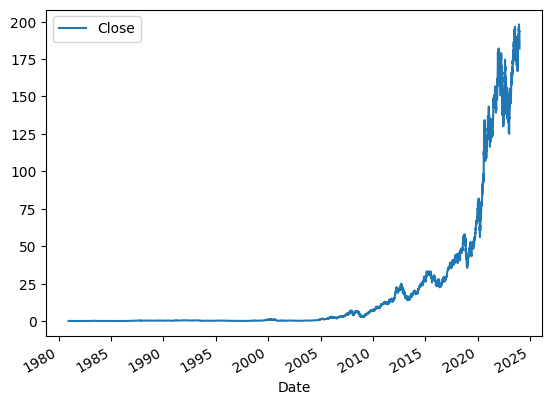

In [9]:
pandas_df.plot.line(y="Close", use_index=True)

<Axes: xlabel='Date'>

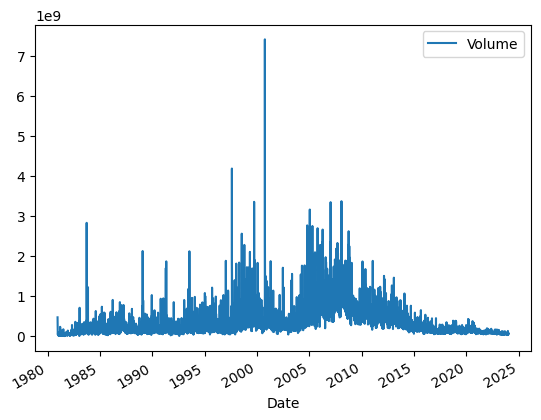

In [10]:
pandas_df.plot.line(y="Volume", use_index=True)

## 2. Chia dữ liệu để huấn luyện mô hình

In [11]:
# Dự đoán 15 ngày sau dựa vào 15 ngày trước.
forecast_out =15
window_spec = Window().orderBy("Date") 
data = data.withColumn("Close_after_n_days", F.lead("Close", forecast_out).over(window_spec))

In [12]:
data.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-------------------+
|               Date|               Open|               High|                Low|              Close|          Adj Close|   Volume| Close_after_n_days|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-------------------+
|1980-12-12 00:00:00| 0.1283479928970337| 0.1289059966802597| 0.1283479928970337| 0.1283479928970337|0.09931866079568863|469033600| 0.1439729928970337|
|1980-12-15 00:00:00|0.12221000343561172|0.12221000343561172|0.12165199965238571|0.12165199965238571|0.09413713216781616|175884800|0.13783499598503113|
|1980-12-16 00:00:00| 0.1132809966802597| 0.1132809966802597|0.11272300034761429|0.11272300034761429|0.08722767233848572|105728000|0.13504500687122345|
|1980-12-17 00:00:00|0.11551299691200256|0.11607100069522858|0.11551299691200256|0.11551

In [13]:
df = data.toPandas()
df.tail(30)

,Date,Open,High,Low,Close,Adj Close,Volume,Close_after_n_days
10826,2023-11-21,191.410004,191.520004,189.740005,190.639999,190.639999,38134500,197.960007
10827,2023-11-22,191.490005,192.929993,190.830002,191.309998,191.309998,39617700,198.110001
10828,2023-11-24,190.869995,190.899994,189.250000,189.970001,189.970001,24048300,197.570007
10829,2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600,195.889999
10830,2023-11-28,189.779999,191.080002,189.399994,190.399994,190.399994,38415400,196.940002
10831,2023-11-29,190.899994,192.089996,188.970001,189.369995,189.369995,43014200,194.830002
10832,2023-11-30,189.839996,190.320007,188.190002,189.949997,189.949997,48794400,194.679993
10833,2023-12-01,190.330002,191.559998,189.229996,191.240005,191.240005,45679300,193.600006
10834,2023-12-04,189.979996,190.050003,187.449997,189.429993,189.429993,43389500,193.050003
10835,2023-12-05,190.210007,194.399994,190.179993,193.419998,193.419998,66628400,193.149994


In [14]:
# New DataFrame with only relevant data
df_new = data.select("Close", "Close_after_n_days")

# Show the resulting DataFrame
df_new.show(30)

+-------------------+-------------------+
|              Close| Close_after_n_days|
+-------------------+-------------------+
| 0.1283479928970337| 0.1439729928970337|
|0.12165199965238571|0.13783499598503113|
|0.11272300034761429|0.13504500687122345|
|0.11551299691200256|0.14229899644851685|
|0.11886200308799744|  0.141183003783226|
|0.12611599266529083|0.13616099953651428|
| 0.1322540044784546| 0.1367190033197403|
|0.13783499598503113|0.13950900733470917|
|0.14508900046348572|0.13839299976825714|
|0.15848200023174286|0.14676299691200256|
|0.16071400046348572|0.14229899644851685|
|  0.156808003783226|0.14508900046348572|
| 0.1523440033197403|0.14676299691200256|
|0.15401799976825714|0.14620499312877655|
|0.15067000687122345| 0.1439729928970337|
| 0.1439729928970337|0.14285700023174286|
|0.13783499598503113|0.13839299976825714|
|0.13504500687122345| 0.1333709955215454|
|0.14229899644851685|0.12611599266529083|
|  0.141183003783226|0.11886200308799744|
|0.13616099953651428|0.12332600355

In [15]:
# Select rows where 'Close_after_n_days' is NaN
df_forecast = df_new.filter(isnull("Close_after_n_days"))
feature_col = ["Close"]
# Vector Assembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_assembled_forecast = assembler.transform(df_forecast).select("features", "Close_after_n_days")
# Show the resulting DataFrame
df_assembled_forecast.show(truncate=False)

+--------------------+------------------+
|features            |Close_after_n_days|
+--------------------+------------------+
|[197.9600067138672] |NULL              |
|[198.11000061035156]|NULL              |
|[197.57000732421875]|NULL              |
|[195.88999938964844]|NULL              |
|[196.94000244140625]|NULL              |
|[194.8300018310547] |NULL              |
|[194.67999267578125]|NULL              |
|[193.60000610351562]|NULL              |
|[193.0500030517578] |NULL              |
|[193.14999389648438]|NULL              |
|[193.5800018310547] |NULL              |
|[192.52999877929688]|NULL              |
|[185.63999938964844]|NULL              |
|[184.25]            |NULL              |
|[181.91000366210938]|NULL              |
+--------------------+------------------+



In [16]:
# All columns of known data except labels, discard last 35 rows
y_col = "Close_after_n_days"
feature_cols = [col for col in df_new.columns if col != y_col]
df_features = df_new.select(*feature_cols, "Close_after_n_days").limit(df_new.count() - forecast_out)

# Vector Assembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_features).select("features", "Close_after_n_days")

In [17]:
df_features.toPandas().tail(10)

,Close,Close_after_n_days
10831,189.369995,194.830002
10832,189.949997,194.679993
10833,191.240005,193.600006
10834,189.429993,193.050003
10835,193.419998,193.149994
10836,192.320007,193.580002
10837,194.270004,192.529999
10838,195.710007,185.639999
10839,193.179993,184.250000
10840,194.710007,181.910004


In [18]:
df_assembled.show(truncate=False)

+---------------------+-------------------+
|features             |Close_after_n_days |
+---------------------+-------------------+
|[0.1283479928970337] |0.1439729928970337 |
|[0.12165199965238571]|0.13783499598503113|
|[0.11272300034761429]|0.13504500687122345|
|[0.11551299691200256]|0.14229899644851685|
|[0.11886200308799744]|0.141183003783226  |
|[0.12611599266529083]|0.13616099953651428|
|[0.1322540044784546] |0.1367190033197403 |
|[0.13783499598503113]|0.13950900733470917|
|[0.14508900046348572]|0.13839299976825714|
|[0.15848200023174286]|0.14676299691200256|
|[0.16071400046348572]|0.14229899644851685|
|[0.156808003783226]  |0.14508900046348572|
|[0.1523440033197403] |0.14676299691200256|
|[0.15401799976825714]|0.14620499312877655|
|[0.15067000687122345]|0.1439729928970337 |
|[0.1439729928970337] |0.14285700023174286|
|[0.13783499598503113]|0.13839299976825714|
|[0.13504500687122345]|0.1333709955215454 |
|[0.14229899644851685]|0.12611599266529083|
|[0.141183003783226]  |0.1188620

In [19]:
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(df_assembled.count() * 0.8)
df_train = df_assembled.limit(train_count)
df_test = df_assembled.subtract(df_train)

In [20]:
df_train.show()

+--------------------+-------------------+
|            features| Close_after_n_days|
+--------------------+-------------------+
|[0.1283479928970337]| 0.1439729928970337|
|[0.12165199965238...|0.13783499598503113|
|[0.11272300034761...|0.13504500687122345|
|[0.11551299691200...|0.14229899644851685|
|[0.11886200308799...|  0.141183003783226|
|[0.12611599266529...|0.13616099953651428|
|[0.1322540044784546]| 0.1367190033197403|
|[0.13783499598503...|0.13950900733470917|
|[0.14508900046348...|0.13839299976825714|
|[0.15848200023174...|0.14676299691200256|
|[0.16071400046348...|0.14229899644851685|
| [0.156808003783226]|0.14508900046348572|
|[0.1523440033197403]|0.14676299691200256|
|[0.15401799976825...|0.14620499312877655|
|[0.15067000687122...| 0.1439729928970337|
|[0.1439729928970337]|0.14285700023174286|
|[0.13783499598503...|0.13839299976825714|
|[0.13504500687122...| 0.1333709955215454|
|[0.14229899644851...|0.12611599266529083|
| [0.141183003783226]|0.11886200308799744|
+----------

In [21]:
df_train.count()

8672

In [22]:
df_test.show()

+--------------------+------------------+
|            features|Close_after_n_days|
+--------------------+------------------+
| [32.17499923706055]|32.404998779296875|
|[31.450000762939453]|  33.0099983215332|
|[31.252500534057617]| 32.94499969482422|
|[31.315000534057617]| 32.56999969482422|
|[31.905000686645508]|  32.6349983215332|
|[31.579999923706055]|  32.4900016784668|
|[31.467500686645508]|32.529998779296875|
|[31.502500534057617]| 32.34000015258789|
| [32.23749923706055]|32.162498474121094|
|[32.192501068115234]|31.950000762939453|
| [32.54750061035156]|31.854999542236328|
| [32.51750183105469]|32.220001220703125|
| [32.51499938964844]|32.147499084472656|
| [32.84749984741211]|31.792499542236328|
|  [33.1349983215332]|31.729999542236328|
|[32.404998779296875]|31.899999618530273|
|  [33.0099983215332]|31.825000762939453|
| [32.94499969482422]|31.969999313354492|
| [32.56999969482422]|31.649999618530273|
|  [32.6349983215332]| 31.90250015258789|
+--------------------+------------

In [23]:
df_test.count()

2169

## 3. Xây dựng mô hình GBT

In [24]:
GBT = GBTRegressor (featuresCol="features", labelCol="Close_after_n_days", maxDepth=3, maxBins=32, stepSize=0.1, seed=42)

In [25]:
model = GBT.fit(df_train)

### 3.1 Kiểm tra tập test

In [26]:
predic_test = model.transform(df_test)

In [27]:
print(predic_test.show())

+--------------------+------------------+------------------+
|            features|Close_after_n_days|        prediction|
+--------------------+------------------+------------------+
| [32.17499923706055]|32.404998779296875|27.185335386554513|
|[31.450000762939453]|  33.0099983215332|27.185335386554513|
|[31.252500534057617]| 32.94499969482422|27.185335386554513|
|[31.315000534057617]| 32.56999969482422|27.185335386554513|
|[31.905000686645508]|  32.6349983215332|27.185335386554513|
|[31.579999923706055]|  32.4900016784668|27.185335386554513|
|[31.467500686645508]|32.529998779296875|27.185335386554513|
|[31.502500534057617]| 32.34000015258789|27.185335386554513|
| [32.23749923706055]|32.162498474121094|27.185335386554513|
|[32.192501068115234]|31.950000762939453|27.185335386554513|
| [32.54750061035156]|31.854999542236328|27.185335386554513|
| [32.51750183105469]|32.220001220703125|27.185335386554513|
| [32.51499938964844]|32.147499084472656|27.185335386554513|
| [32.84749984741211]|31

In [28]:
evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="rmse")
rmse_test = evaluator_rmse.evaluate(predic_test)
print("Root Mean Squared Error (RMSE) on test data =", rmse_test)

evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="r2")
r2_test = evaluator_rmse.evaluate(predic_test)
print("R2 on test data =", r2_test)

Root Mean Squared Error (RMSE) on test data = 81.74122744698323
R2 on test data = -1.1175273752544457


In [29]:
from pyspark.sql.functions import abs

def calculate_mape(df, labelCol, predictionCol):
    df = df.withColumn("absolute_error", abs(df[labelCol] - df[predictionCol]))
    df = df.withColumn("percentage_error", df["absolute_error"] / df[labelCol] * 100)
    mape = df.select("percentage_error").agg({"percentage_error": "avg"}).collect()[0][0]
    return mape

mape_test = calculate_mape(predic_test, "Close_after_n_days", "prediction")
print("Mean Absolute Percentage Error (MAPE) on test data =", mape_test)

Mean Absolute Percentage Error (MAPE) on test data = 51.59037018356589


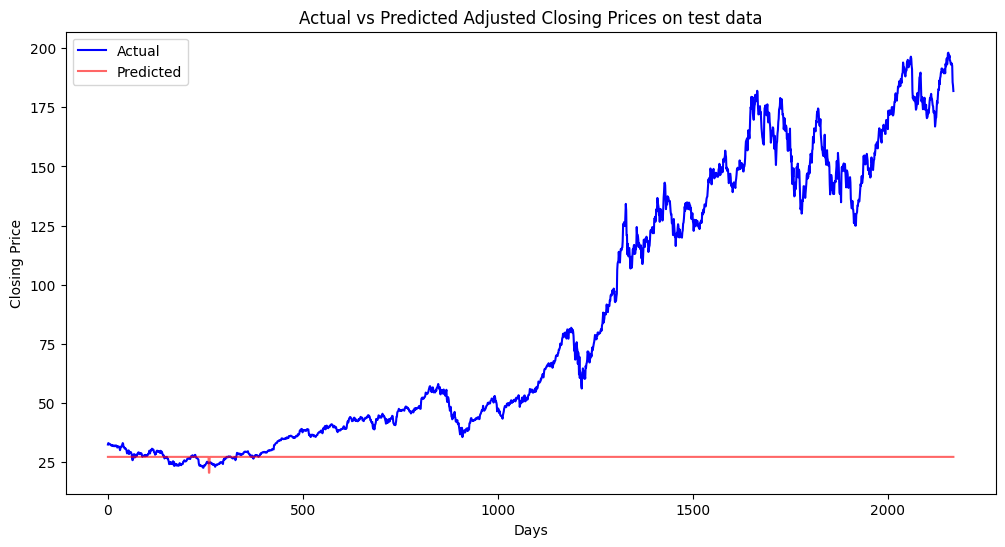

In [30]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predic_test.select("Close_after_n_days", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close_after_n_days"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices on test data')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### 3.2 Kiểm tra tập train

In [31]:
predic_train = model.transform(df_train)

In [32]:
predic_train.show()

+--------------------+-------------------+-------------------+
|            features| Close_after_n_days|         prediction|
+--------------------+-------------------+-------------------+
|[0.1283479928970337]| 0.1439729928970337|0.14655870513232008|
|[0.12165199965238...|0.13783499598503113|0.14655870513232008|
|[0.11272300034761...|0.13504500687122345| 0.1412595761322924|
|[0.11551299691200...|0.14229899644851685| 0.1412595761322924|
|[0.11886200308799...|  0.141183003783226|0.14655870513232008|
|[0.12611599266529...|0.13616099953651428|0.14655870513232008|
|[0.1322540044784546]| 0.1367190033197403|0.14655870513232008|
|[0.13783499598503...|0.13950900733470917|0.15907071468106793|
|[0.14508900046348...|0.13839299976825714|0.15907071468106793|
|[0.15848200023174...|0.14676299691200256|0.17842182755629216|
|[0.16071400046348...|0.14229899644851685|0.17842182755629216|
| [0.156808003783226]|0.14508900046348572|0.17842182755629216|
|[0.1523440033197403]|0.14676299691200256|0.17842182755

In [33]:
evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator_rmse.evaluate(predic_train)
print("Root Mean Squared Error (RMSE) on train data =", rmse_train)

evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="r2")
r2_train = evaluator_rmse.evaluate(predic_train)
print("R2 on train data =", r2_train)

Root Mean Squared Error (RMSE) on train data = 0.851358228709828
R2 on train data = 0.9838913372266715


In [34]:
from pyspark.sql.functions import abs

def calculate_mape(df, labelCol, predictionCol):
    df = df.withColumn("absolute_error", abs(df[labelCol] - df[predictionCol]))
    df = df.withColumn("percentage_error", df["absolute_error"] / df[labelCol] * 100)
    mape = df.select("percentage_error").agg({"percentage_error": "avg"}).collect()[0][0]
    return mape

mape_train = calculate_mape(predic_train, "Close_after_n_days", "prediction")
print("Mean Absolute Percentage Error (MAPE) on train data =", mape_train)

Mean Absolute Percentage Error (MAPE) on train data = 15.0087096737951


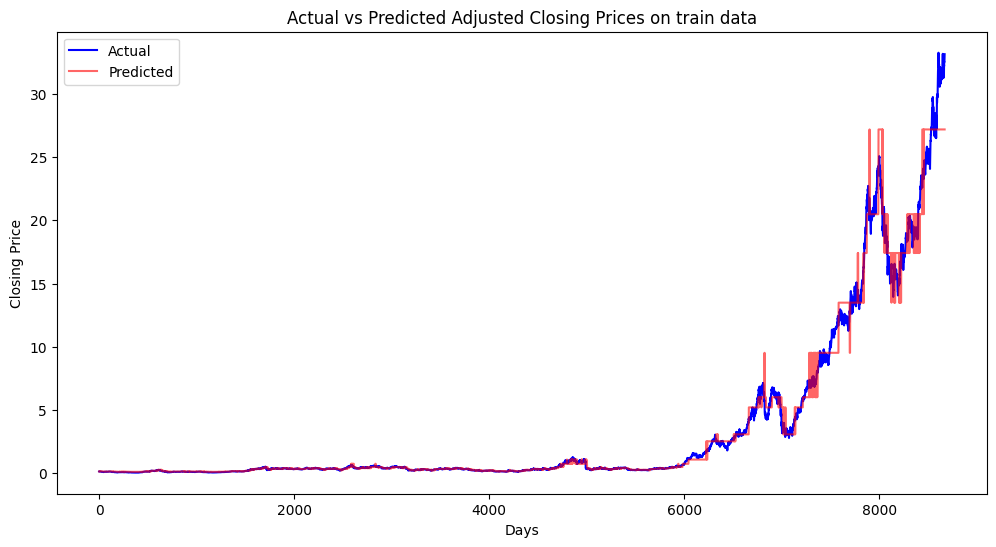

In [35]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predic_train.select("Close_after_n_days", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close_after_n_days"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices on train data')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()